1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
0 [D loss: 3.7985732555389404] [G loss: [array(1.3866963, dtype=float32), array(1.3866963, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


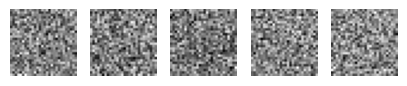

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1 [D loss: 3.1455559730529785] [G loss: [array(1.4766011, dtype=float32), array(1.4766011, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2 [D loss: 3.321218490600586] [G loss: [array(1.6136421, dtype=float32), array(1.6136421, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3 [D loss: 3.4443612098693848] [G loss: [array(1.727562, dtype=float32), array(1.727562, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4 [D loss: 3.651893138885498] [G loss: [array(1.8449463, dtype=float32), array(1.8449463, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
5 [D loss: 3.8314645290374756] [G loss: [array(1.9451941, dtype=float32), array(1.9451941, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6 [D loss: 4.042427062988281] [G loss: [array(2.0580494, dtype=float32), array(2.0580494, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
7 [D loss: 4.2483720779418945] [G loss: [array(2.1773942, dtype=float32), array(2.1773942, 

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5  # Normalize to [-1, 1]

# Hyperparameters
latent_dim = 100
batch_size = 32
epochs = 100  # Reduced number of epochs for faster training

# Generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Build and compile the GAN
def build_gan(generator, discriminator):
    discriminator.compile(optimizer='adam', loss='binary_crossentropy')
    discriminator.trainable = False
    model = tf.keras.Sequential([generator, discriminator])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

# Instantiate the generator and discriminator
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

# Function to generate and save images
def generate_and_save_images(epoch, generator, examples=5):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]

    plt.figure(figsize=(5, 1))
    for i in range(examples):
        plt.subplot(1, examples, i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

# Training loop
def train_gan(generator, discriminator, gan, epochs, batch_size):
    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        # Train discriminator with real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_images = X_train[idx]
        real_labels = np.ones((half_batch, 1))

        # Train discriminator with fake images
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

        # Train generator (via the GAN model)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))  # Fake images are labeled as real
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Print progress
        print(f"{epoch} [D loss: {d_loss_real + d_loss_fake}] [G loss: {g_loss}]")

        # Generate and display images every 20 epochs
        if epoch % 100 == 0:
            generate_and_save_images(epoch, generator)

# Train the GAN
train_gan(generator, discriminator, gan, epochs=10, batch_size=32)